## **Marco teórico**


**Referencia: An introduction to KMC models in surfaces**

$$
\Gamma_{\text{dep}} = \nu_a \exp\left(\frac{E_{\text{dep}}}{k_B T}\right), \\
\Gamma_{\text{diss}} = \nu_a \exp\left(-\frac{n_n \phi_{\text{ss}}}{k_B T}\right), \\
\Gamma_{\text{diff}} = \nu_d \exp\left(\frac{E_A - E_B}{k_B T}\right)
$$

donde $\nu_a$ es la frecuencia del evento (s$^{-1}$), $\phi_{\text{ss}}$ es la energía potencial promedio entre los átomos sólidos (eV), $n_n$ es el número de primeros vecinos ocupados, $\nu_d$ es la frecuencia vibracional atómica para la difusión (s$^{-1}$), y $E_A$ y $E_B$ son las energías del sistema antes y después del evento (eV). $E_A$ y $E_B$ también son funciones de $n_n$, así como de las energías de interacción sólido-sólido, fluido-fluido y sólido-fluido. El Hamiltoniano también depende de $n_n$, de las energías de interacción sólido-sólido, fluido-fluido y sólido-fluido, y del estado del sistema.


**Referencia: Monte Carlo and Kinetic Monte Carlo
Methods - A Tutorial**

La tasa del proceso $i$ puede expresarse como:
\begin{equation}
w_i = w_i^{(0)} \exp\left(-\frac{\Delta E_i}{k_B T}\right),
\end{equation}
donde $w_i^{(0)} = \frac{k_B T}{h} \exp\left(\frac{\Delta S_i^{\text{vib}}}{k_B}\right)$ se denomina frecuencia de intento.

Las dos cantidades básicas en la Ec.~(24), $w_i^{(0)}$ y $\Delta E_i$, pueden obtenerse a partir de cálculos DFT. Si nos limitamos a la difusión de una sola partícula y descartamos la contribución de la energía vibracional térmica, $\Delta E_i$ puede extraerse directamente de la superficie de energía potencial (PES).



**Referencia: Kinetic Monte Carlo approach for molecular modeling of adsorption**

En el caso general, la tasa $r_{i,j}$ de la molécula $i$ en la configuración $j$-ésima se expresa como:
\begin{equation}
r_{i,j} = \exp\left[\beta \left(u_i^{\text{ext}} + u_{i,j}\right)\right],
\end{equation}
donde $\beta = \frac{1}{k_B T}$, $u_i^{\text{ext}}$ es el potencial externo, $u_{i,j}$ es el potencial de la molécula $i$ interactuando con todas las demás moléculas, $T$ es la temperatura y $k_B$ es la constante de Boltzmann.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def pick_random_site(lattice):
    i,j = np.random.randint(0, len(lattice), size=2)
    site = i,j
    return site

def count_occupied_neighbors(lattice, site):
    neighbors = 0
    i, j = site
    for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
      if 0 <= ni < len(lattice) and 0 <= nj < len(lattice):
        neighbors += lattice[ni, nj]
    return neighbors

def hamiltonian(e_int,site):
  n_ij = count_occupied_neighbors(lattice, site)
  H = e_int * n_ij + E_ads
  return H

def calculate_transition_rates(lattice, site):
    H = hamiltonian(e_int, site)
    k_ads = (k_b*T)/h * np.exp(-H /(k_b*T))
    k_des = (k_b*T)/h * np.exp(-E_des/(k_b*T))
    k_diff = (k_b*T)/h * np.exp(-E_diff/(k_b*T))
    k_total = k_ads + k_des + k_diff
    return k_ads, k_des, k_diff, k_total

def select_event(k_ads,k_des,k_diff):
    # Select which event occurs
    total_propensity = k_ads + k_des + k_diff
    r = np.random.rand() * total_propensity
    if r < k_ads:
        return "adsorption"
    elif r < k_ads + k_des:
        return "desorption"
    else:
        return "diffusion"


In [ ]:
# Parameters
lattice_size = 100  # 10x10 grid of adsorption sites
E_ads = 6      # adsorption rate
E_des = 400
E_diff = 1000
e_int = 1000000          # Interaction energy
coverage = 0.2     # coverage percentage
T = 300
k_b = 1 #8.617e-5
h = 1 #6.626e-34


# Number of sites for fill
num_sites = lattice_size**2
num_filled_sites = int(num_sites * coverage)

# Initialize lattice (0 = vacant, 1 = occupied)
lattice = np.zeros((lattice_size, lattice_size))
time = 0.0
times = [time]
states = [lattice.copy()]

In [ ]:
num_occupied_sites = 0
end_time = 100


while time < end_time :

    site = pick_random_site(lattice)

    # Calculate propensities and total propensity
    k_ads, k_des, k_diff, k_total = calculate_transition_rates(lattice, site)
    print(k_ads, k_des, k_diff, k_total)

    if k_total == 0:
        break  # No more events possible

    # Determine the time to the next event
    delta_t = -np.log(np.random.rand()) / k_total
    time += delta_t
    print(time)


    # Select the event type
    event_type = select_event(k_ads, k_des, k_diff)

    print(event_type)

    # Here, we must consider the coverage percentage
    if event_type == "adsorption" :
        lattice[site] = 1

    elif event_type == "desorption":
        lattice[site] = 0

    elif event_type == "diffusion" :
        if lattice[site] == 1:
          neighbors = [(site[0] + dx, site[1] + dy)
                      for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                      if 0 <= site[0] + dx < lattice_size and 0 <= site[1] + dy < lattice_size]
          vacant_neighbors = [s for s in neighbors if lattice[s] == 0]
          if vacant_neighbors:
              new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
              lattice[site], lattice[new_site] = 0, 1  # Move particle to new site
        else:
          lattice[site] = 0

    num_occupied_sites = int(np.sum(lattice==1))
    times.append(time)
    states.append(lattice.copy())


294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.007163281228107299
desorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.010951444328163298
desorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.016751943894509902
adsorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.021194973649211666
adsorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.02295291788005241
desorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.02324836350371213
adsorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.023768300779751134
adsorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.026131247358304015
adsorption
294.05960199202656 79.07914143471803 10.702198004175719 383.8409414309203
0.029636800655055515
adsorption
294.05960199202656 79.07914143471803 10.70219800

KeyboardInterrupt: 

In [ ]:
# Plot the final lattice state
plt.imshow(lattice, cmap='binary')
plt.title("Final lattice state")
plt.show()

# Plot percentage of occupied sites over time
occupancy = [np.sum(state == 1) / (lattice_size**2) * 100 for state in states]
plt.plot(np.array(times), occupancy)
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()


## **INTENTO CONSIDERANDO NUEVOS PARÁMETROS E INTERACCIONES**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def pick_random_site(lattice):
    i,j = np.random.randint(0, len(lattice), size=2)
    site = i,j
    return site

def count_occupied_neighbors(lattice, site):
    neighbors = 0
    i, j = site
    for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
      if 0 <= ni < len(lattice) and 0 <= nj < len(lattice):
        neighbors += lattice[ni, nj]
    return neighbors

def activation_energies(e_int_abs,e_int_des ,site):
  n_ij = count_occupied_neighbors(lattice, site)
  ads = e_int_abs * n_ij + e_ads
  des = -e_int_des * n_ij + e_des
  return ads, des

def calculate_transition_rates(lattice, site):
    E_ads, E_des = activation_energies(e_int_abs, e_int_des, site)

    k_ads = (k_b*T)/h * np.exp(-E_ads /(k_b*T))
    k_des = (k_b*T)/h * np.exp(-E_des/(k_b*T))
    k_diff = (k_b*T)/h * np.exp(-e_diff/(k_b*T))
    k_total = k_ads + k_des + k_diff
    return k_ads, k_des, k_diff, k_total

def select_event(k_ads,k_des,k_diff):
    # Select which event occurs
    total_propensity = k_ads + k_des + k_diff
    r = np.random.rand() * total_propensity
    if r < k_ads:
        return "adsorption"
    elif r < k_ads + k_des:
        return "desorption"
    else:
        return "diffusion"


In [ ]:
lattice_size = 100
lattice = np.zeros((lattice_size, lattice_size))


# Transition energies
e_ads = -300
e_des = 400
e_diff = 1000

# Interaction energies
e_int_abs = 100
e_int_des = 10

# Parameters and initial conditions
T = 300
k_b = 1 #8.617e-5
h = 1 #6.626e-34
time = 0.0
times = [time]
states = [lattice.copy()]



In [ ]:
end_time = 30
events_count = {"adsorption": 0 , "desorption":0, "diffusion":0}

while time < end_time :

    site = pick_random_site(lattice)

    # Calculate propensities and total propensity
    k_ads, k_des, k_diff, k_total = calculate_transition_rates(lattice, site)
    # print(k_ads, k_des, k_diff, k_total)

    if k_total == 0:
        break  # No more events possible


    # Determine the time to the next event
    delta_t = -np.log(np.random.rand()) / k_total
    time += delta_t
    print(time)


    # Select the event type
    event_type = select_event(k_ads, k_des, k_diff)

    print(event_type)

    # Here, we must consider the coverage percentage
    if event_type == "adsorption" :
        lattice[site] = 1
        events_count["adsorption"] += 1


    elif event_type == "desorption":
        lattice[site] = 0
        events_count["desorption"] += 1

    elif event_type == "diffusion" :
        events_count["diffusion"] += 1
        if lattice[site] == 1:
          neighbors = [(site[0] + dx, site[1] + dy)
                      for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                      if 0 <= site[0] + dx < lattice_size and 0 <= site[1] + dy < lattice_size]
          vacant_neighbors = [s for s in neighbors if lattice[s] == 0]
          if vacant_neighbors:
              new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
              lattice[site], lattice[new_site] = 0, 1  # Move particle to new site
        else:
          lattice[site] = 0


    num_occupied_sites = int(np.sum(lattice==1))
    times.append(time)
    states.append(lattice.copy())




Streaming output truncated to the last 5000 lines.
24.18703195474841
desorption
24.187259624245197
desorption
24.190450671520495
adsorption
24.190454337321547
adsorption
24.19217041100653
adsorption
24.196155429681145
desorption
24.19630631122195
adsorption
24.197606014162393
adsorption
24.198103497327583
adsorption
24.200769698327314
adsorption
24.200943785492566
adsorption
24.20472689847799
adsorption
24.206445777620655
adsorption
24.207844676387154
desorption
24.21644234875874
desorption
24.216840394888365
adsorption
24.2192732592246
desorption
24.219431282256515
desorption
24.220383714623335
adsorption
24.220500999363615
adsorption
24.223301392145583
desorption
24.223308875809465
adsorption
24.224203393972687
adsorption
24.224204523825122
adsorption
24.224684714973723
adsorption
24.22482668584402
adsorption
24.225654345942214
desorption
24.226622210206152
adsorption
24.227676382004137
adsorption
24.228784300326133
adsorption
24.228834947433803
adsorption
24.230980550897137
adsorpti

In [ ]:
occupancy = [np.sum(state == 1) / (lattice_size**2) * 100 for state in states]

slope = (occupancy[int(len(states)*0.03)]-occupancy[0])/(times[int(len(states)*0.03)]-times[0])
print(events_count)
print(slope)

{'adsorption': 13102, 'desorption': 2609, 'diffusion': 309}
7.143948619519742


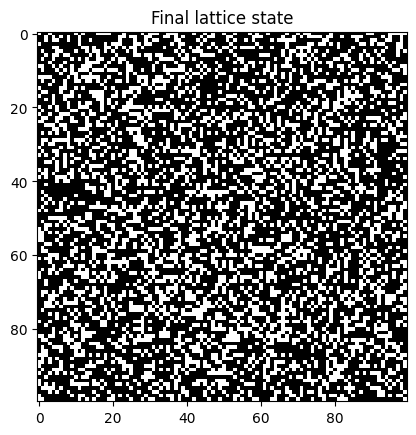

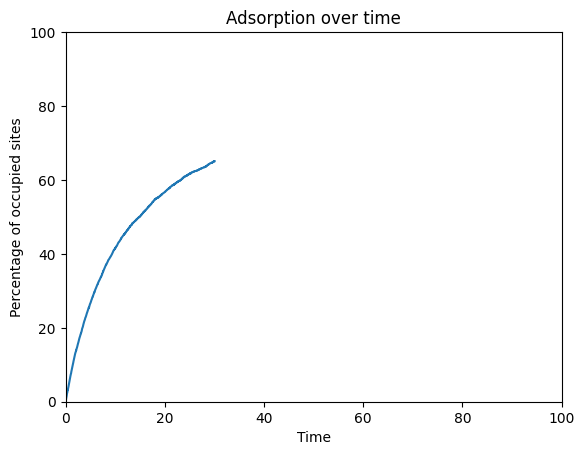

In [ ]:
# Plot the final lattice state
plt.imshow(lattice, cmap='binary')
plt.title("Final lattice state")
plt.show()

# Plot percentage of occupied sites over time
plt.plot(np.array(times), occupancy)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()


## **Implementando un modelo ML para la obtención de curvas**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

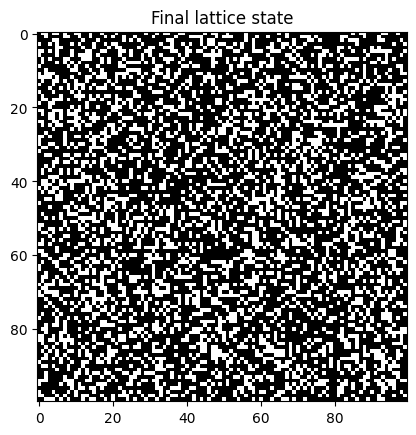

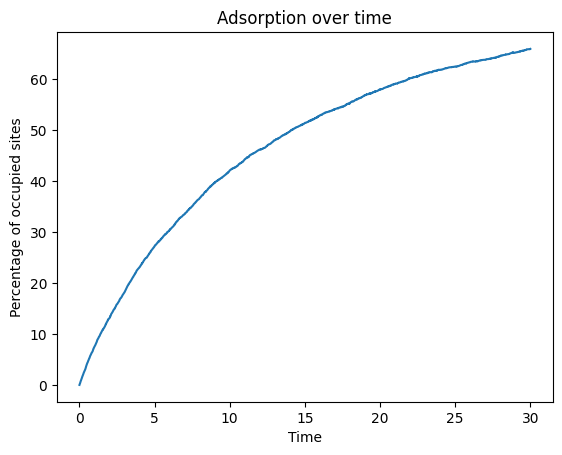

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class KineticMonteCarlo:
    def __init__(self, lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_des = e_des
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.e_int_des = e_int_des
        self.k_b = 1  # Boltzmann constant (arbitrary unit)
        self.h = 1  # Planck constant (arbitrary unit)
        self.time = 0.0
        self.times = [self.time]
        self.states = [self.lattice.copy()]
        self.events_count = {"adsorption": 0, "desorption": 0, "diffusion": 0}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        des = -self.e_int_des * n_ij + self.e_des
        return ads, des

    def calculate_transition_rates(self, site):
        E_ads, E_des = self.activation_energies(site)
        k_ads = (self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        k_des = (self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
        k_diff = (self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T))
        k_total = k_ads + k_des + k_diff
        return k_ads, k_des, k_diff, k_total

    def select_event(self, k_ads, k_des, k_diff):
        total_propensity = k_ads + k_des + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        elif r < k_ads + k_des:
            return "desorption"
        else:
            return "diffusion"

    def run_simulation(self, end_time):
        while self.time < end_time:
            site = self.pick_random_site()
            k_ads, k_des, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            delta_t = -np.log(np.random.rand()) / k_total
            self.time += delta_t

            event_type = self.select_event(k_ads, k_des, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "desorption":
                self.lattice[site] = 0
                self.events_count["desorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.times.append(self.time)
            self.states.append(self.lattice.copy())

    def plot_final_state(self):
        plt.imshow(self.lattice, cmap='binary')
        plt.title("Final lattice state")
        plt.show()

    def plot_occupancy_over_time(self):
        occupancy = [np.sum(state == 1) / (self.lattice_size ** 2) * 100 for state in self.states]
        plt.plot(self.times, occupancy)
        plt.xlabel("Time")
        plt.ylabel("Percentage of occupied sites")
        plt.title("Adsorption over time")
        plt.show()

# Parameters
lattice_size = 100
T = 300
e_ads = -300
e_des = 400
e_diff = 1000
e_int_abs = 100
e_int_des = 10
end_time = 30

# Simulation
kmc = KineticMonteCarlo(lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des)
kmc.run_simulation(end_time)
kmc.plot_final_state()
kmc.plot_occupancy_over_time()


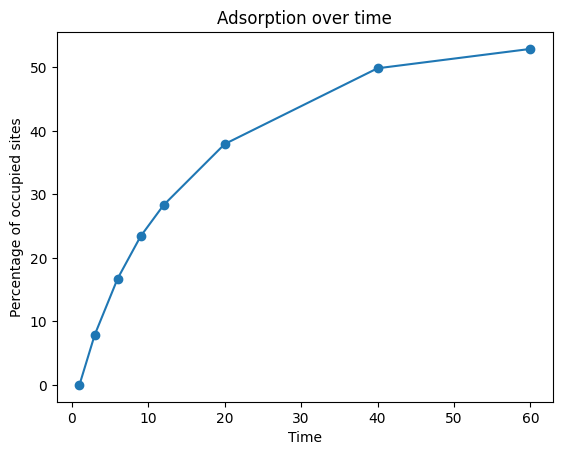

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class KineticMonteCarlo_byarray:
    def __init__(self, lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_des = e_des
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.e_int_des = e_int_des
        self.k_b = 1  # Boltzmann constant (arbitrary unit)
        self.h = 1  # Planck constant (arbitrary unit)
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {"adsorption": 0, "desorption": 0, "diffusion": 0}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        des = -self.e_int_des * n_ij + self.e_des
        return ads, des

    def calculate_transition_rates(self, site):
        E_ads, E_des = self.activation_energies(site)
        k_ads = (self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        k_des = (self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
        k_diff = (self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T))
        k_total = k_ads + k_des + k_diff
        return k_ads, k_des, k_diff, k_total

    def select_event(self, k_ads, k_des, k_diff):
        total_propensity = k_ads + k_des + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        elif r < k_ads + k_des:
            return "desorption"
        else:
            return "diffusion"

    def run_simulation(self):
        end_time = self.time_array[-1]
        while self.time < end_time:
            site = self.pick_random_site()
            k_ads, k_des, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            delta_t = -np.log(np.random.rand()) / k_total
            self.time += delta_t

            event_type = self.select_event(k_ads, k_des, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "desorption":
                self.lattice[site] = 0
                self.events_count["desorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            # Store occupancy at specific target times
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

    def plot_occupancy(self):
        times = list(self.occupancy.keys())
        values = [self.occupancy[t] for t in times]
        plt.plot(times, values, marker='o')
        plt.xlabel("Time")
        plt.ylabel("Percentage of occupied sites")
        plt.title("Adsorption over time")
        plt.show()

# Parameters
lattice_size = 100
T = 300
e_ads = -100
e_des = 200
e_diff = 1000
e_int_abs = 100
e_int_des = 10
time_array = np.array([1, 3, 6, 9, 12, 20, 40, 60])  # Specify desired times

# Simulation
kmc = KineticMonteCarlo_byarray(lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array)
kmc.run_simulation()
kmc.plot_occupancy()


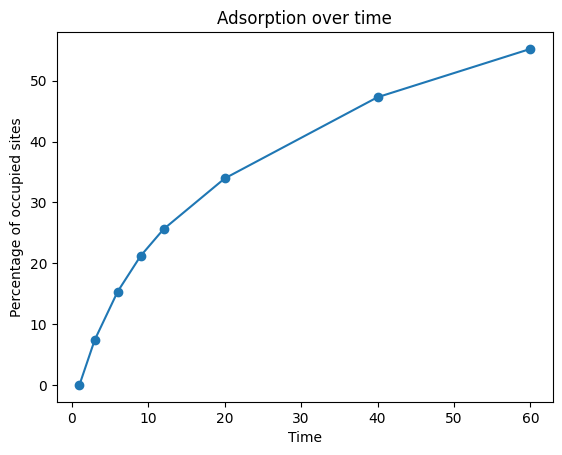

183.35089607515437 -147.84617179964476 410.5616954406045 1445.0457201160993 114.00959125487363 6.055165103265502


{1: 0.01,
 3: 7.41,
 6: 15.35,
 9: 21.2,
 12: 25.6,
 20: 33.94,
 40: 47.29,
 60: 55.230000000000004}

In [ ]:
T = np.random.uniform(300)  # Random temperature between
e_ads = np.random.uniform(-500, -100)  # Random adsorption energy
e_des = np.random.uniform(200, 500)  # Random desorption energy
e_diff = np.random.uniform(500, 1500)  # Random diffusion energy
e_int_abs = np.random.uniform(50, 150)  # Random adsorption interaction energy
e_int_des = np.random.uniform(5, 20)  # Random desorption interaction energy
time_array = np.array([1, 3, 6, 9, 12, 20, 40, 60])  # Specify desired times

# Simulation
kmc = KineticMonteCarlo_byarray(lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array)
kmc.run_simulation()
kmc.plot_occupancy()
print(T,e_ads,e_des,e_diff,e_int_abs,e_int_des)
kmc.occupancy

```python
lattice_size = 100
T = 300
e_ads = -300
e_des = 400
e_diff = 1000
e_int_abs = 100
e_int_des = 10
```

In [ ]:
class KineticMonteCarlo:
    def __init__(self, lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_des = e_des
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.e_int_des = e_int_des
        self.k_b = 1  # Boltzmann constant (arbitrary unit)
        self.h = 1  # Planck constant (arbitrary unit)
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {"adsorption": 0, "desorption": 0, "diffusion": 0}

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        des = -self.e_int_des * n_ij + self.e_des
        return ads, des

    def calculate_transition_rates(self, site):
        E_ads, E_des = self.activation_energies(site)
        k_ads = (self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))
        k_des = (self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
        k_diff = (self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T))
        k_total = k_ads + k_des + k_diff
        return k_ads, k_des, k_diff, k_total

    def select_event(self, k_ads, k_des, k_diff):
        total_propensity = k_ads + k_des + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        elif r < k_ads + k_des:
            return "desorption"
        else:
            return "diffusion"

    def run_simulation(self):
        end_time = self.time_array[-1]
        total_time = end_time - self.time_array[0]
        last_percentage = 0
        i=0
        while self.time < end_time:
            if(i%10==0):
              print(i, self.time,end_time)

            i=i+1
            site = self.pick_random_site()
            k_ads, k_des, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            delta_t = np.log(np.random.rand()) / k_total
            self.time += delta_t

            event_type = self.select_event(k_ads, k_des, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "desorption":
                self.lattice[site] = 0
                self.events_count["desorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            # Store occupancy at specific target times
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100


        return self.occupancy

In [ ]:
from tqdm import tqdm

def run_multiple_simulations(n_simulations, lattice_size, time_array):
    results = []
    parameters = []

    for _ in tqdm(range(n_simulations), desc="Running simulations", unit="simulation"):
        # Generate random parameters for each simulation
        T = np.random.uniform(200, 400)  # Random temperature between 200 and 400
        e_ads = np.random.uniform(-500, -100)  # Random adsorption energy
        e_des = np.random.uniform(200, 500)  # Random desorption energy
        e_diff = np.random.uniform(500, 1500)  # Random diffusion energy
        e_int_abs = np.random.uniform(50, 150)  # Random adsorption interaction energy
        e_int_des = np.random.uniform(5, 20)  # Random desorption interaction energy

        # Initialize the simulation
        kmc = KineticMonteCarlo(lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array)

        # Run the simulation
        occupancy = kmc.run_simulation()

        # Store the occupancy results and corresponding parameters
        results.append(occupancy)
        parameters.append([T, e_ads, e_des, e_diff, e_int_abs, e_int_des])

    return results, np.array(parameters)

def plot_simulations(results, time_array):

    plt.figure(figsize=(10, 6))
    for i, result in enumerate(results):
        times = list(result.keys())
        occupancies = list(result.values())
        plt.plot(times, occupancies, label=f"Simulation {i+1}", alpha=0.7)

    plt.xlabel("Time")
    plt.ylabel("Percentage of Occupied Sites")
    plt.title("Occupancy over Time for Multiple Simulations")
    plt.tight_layout()
    plt.show()


In [ ]:
lattice_size = 100
time_array = np.array([1, 3, 6, 9, 12, 20, 40, 60])  # Target times for each simulation

# Run 10 simulations
n_simulations = 1000
results, parameters = run_multiple_simulations(n_simulations, lattice_size, time_array)


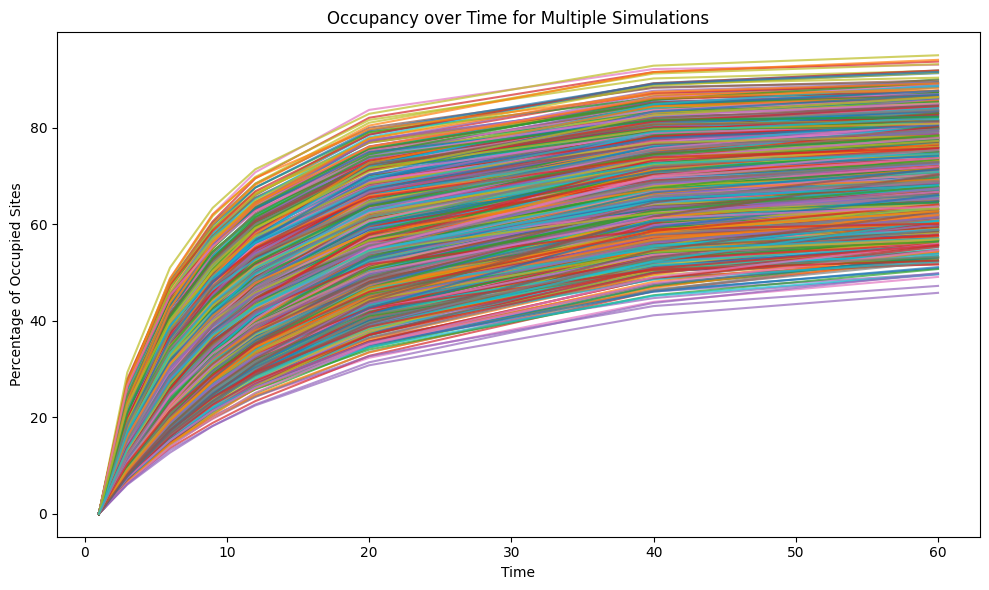

In [ ]:
plot_simulations(results, time_array)

In [ ]:
import numpy as np

def save_simulation_results(filename, results, parameters):

    # Convert the results (list of dicts) into a structured format
    structured_results = {f"simulation_{i+1}": result for i, result in enumerate(results)}

    # Save the results and parameters to an .npz file
    np.savez(filename, results=structured_results, parameters=parameters)
    print(f"Simulation results and parameters saved to {filename}.npz")

def load_simulation_results(filename):

    data = np.load(f"{filename}.npz", allow_pickle=True)
    structured_results = data["results"].item()  # Extract dictionary of results
    parameters = data["parameters"]

    # Convert the structured results back into a list of dicts
    results = [structured_results[f"simulation_{i+1}"] for i in range(len(parameters))]

    return results, parameters

In [ ]:
# Simulate and save
save_simulation_results("simulation_data", results, parameters)

In [ ]:
loaded_results, loaded_parameters = load_simulation_results("simulation_data")

In [ ]:
X = np.array([np.array(list(dic.values())) for dic in loaded_results])
Y = loaded_parameters

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import models, layers
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.optimizers import Adam

In [ ]:


X_norm = X/100

scaler_Y = MinMaxScaler()
scaler_Y.fit(Y)
Y_norm = scaler_Y.transform(Y)


X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y_norm, test_size=0.2, random_state=42)

In [ ]:
np.shape(X_train),np.shape(X_test),np.shape(Y_train),np.shape(Y_test)

((800, 8), (200, 8), (800, 6), (200, 6))

In [ ]:
model = models.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(6)])


learning_rate = 0.001  # Prueba con valores más bajos si quieres un ajuste más fino
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mse')

In [ ]:
history = model.fit(X_train, Y_train, epochs=150, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2894 - val_loss: 0.1734
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1532 - val_loss: 0.1018
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0997 - val_loss: 0.0901
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0909 - val_loss: 0.0885
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0891 - val_loss: 0.0861
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0883 - val_loss: 0.0843
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0848 - val_loss: 0.0830
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0845 - val_loss: 0.0804
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0818 - val_loss: 0.0787
Epoch 10/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0787 - val_loss: 0.0777
Epoch 11/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0770 - val_loss: 0.0754
Epoch 12/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0

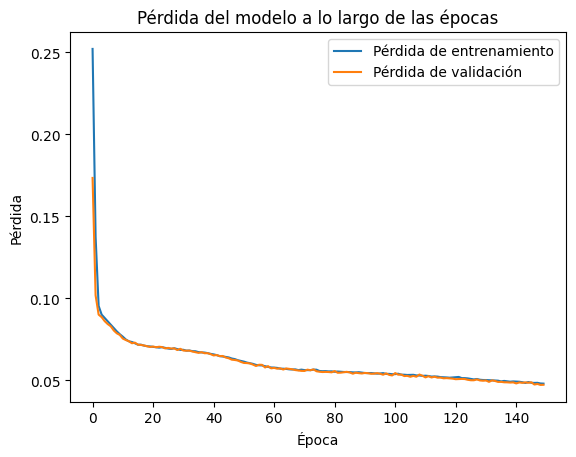

In [ ]:
import matplotlib.pyplot as plt



plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo a lo largo de las épocas')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [ ]:
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f'Pérdida en el conjunto de prueba: {test_loss}')


Pérdida en el conjunto de prueba: 0.04726143926382065


In [ ]:
Y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [ ]:
n=8

print(Y_pred[n])
print(Y_test[n])

[0.49748182 0.8404271  0.6011966  0.5154006  0.39844292 0.48329043]
[0.60757739 0.81907212 0.63540779 0.48191824 0.44872572 0.89289961]


In [ ]:
Y_prueba = scaler_Y.inverse_transform(Y_pred)
T, e_ads, e_des, e_diff, e_int_abs, e_int_des = Y_prueba[8]

X_prueba = X_test*100
X_prueba[8]

array([ 0.  ,  9.64, 20.17, 28.19, 34.84, 47.44, 60.81, 65.61])

In [ ]:
lattice_size = 100
time_array = np.array([1, 3, 6, 9, 12, 20, 40, 60])

kmc = KineticMonteCarlo(lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array)

occupancy = kmc.run_simulation()

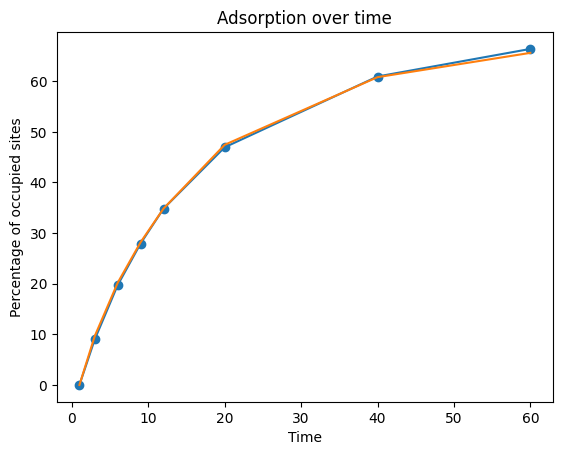

In [ ]:
plt.plot(time_array,occupancy.values(), marker='o')
plt.plot(time_array,X_prueba[8])
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

In [ ]:
import pandas as pd

data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data

,T1,T2,T3,T4,T5,T6,T7,T8
0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587
1,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691
2,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964
3,11.453131,16.961002,22.642191,31.064719,36.995999,40.164993,40.562844,41.061651
4,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360
5,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871
6,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965
7,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876
8,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996
9,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952


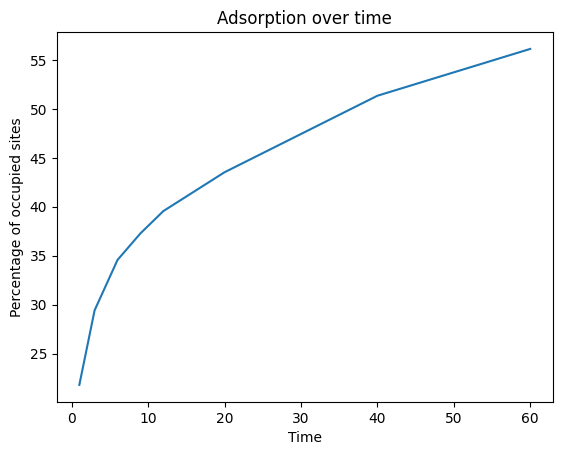

In [ ]:
exp_data = data.iloc[8]
plt.plot(time_array,exp_data)
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

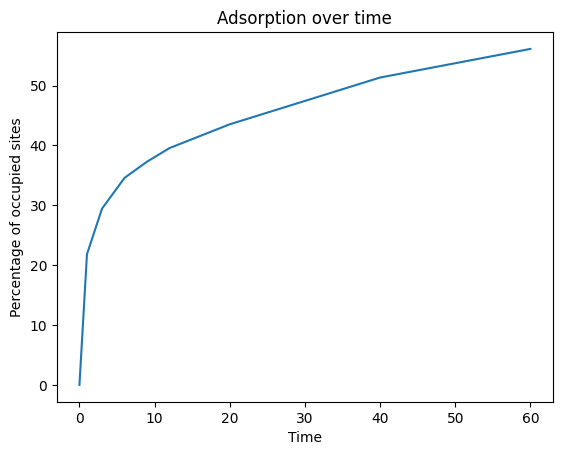

In [ ]:

exp_data = np.insert(exp_data, 0, 0)

plt.plot(np.insert(time_array, 0, 0), exp_data) #Plot with the new time array
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

In [ ]:
np.shape(exp_data)

(8,)

In [ ]:
dato = np.expand_dims(exp_data, axis=0)
np.shape(dato)

(1, 8)

In [ ]:
Y_pred = model.predict(dato)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [ ]:
parametros =scaler_Y.inverse_transform(Y_pred)
parametros

array([[-33163.477  , -18928.658  ,  30429.574  ,  19418.867  ,
          8566.96   ,    384.75027]], dtype=float32)

In [ ]:
time_array = np.array([0,0.1, 0.3, 0.6, 0.9, 1.2, 2.0])
T, e_ads, e_des, e_diff, e_int_abs, e_int_des = parametros[0]
kmc = KineticMonteCarlo(lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array)

occupancy = kmc.run_simulation()

Streaming output truncated to the last 5000 lines.
330380 1.7394609945799298 2.0
330390 1.739504726101436 2.0
330400 1.7395369849334035 2.0
330410 1.739579622454321 2.0
330420 1.7396189165928562 2.0
330430 1.7396744061720804 2.0
330440 1.739782815000457 2.0
330450 1.7398499456893513 2.0
330460 1.7399241090154702 2.0
330470 1.7399863124220882 2.0
330480 1.740025157254985 2.0
330490 1.7401084523097925 2.0
330500 1.7401664835517323 2.0
330510 1.7402185939225192 2.0
330520 1.7402924787535732 2.0
330530 1.7403477493035555 2.0
330540 1.7403775266228778 2.0
330550 1.7404217757873557 2.0
330560 1.7404670382868868 2.0
330570 1.7405293032452025 2.0
330580 1.7405622574642783 2.0
330590 1.740599023035329 2.0
330600 1.7406530457335776 2.0
330610 1.7406988650661623 2.0
330620 1.740742328281367 2.0
330630 1.740777312579769 2.0
330640 1.7408357271040353 2.0
330650 1.7408741809206771 2.0
330660 1.7409027211271033 2.0
330670 1.7409271047261665 2.0
330680 1.7409750714105483 2.0
330690 1.7410436437804817 

In [ ]:
time_array/

array([0.1, 0.3, 0.6, 0.9, 1.2, 2. ])

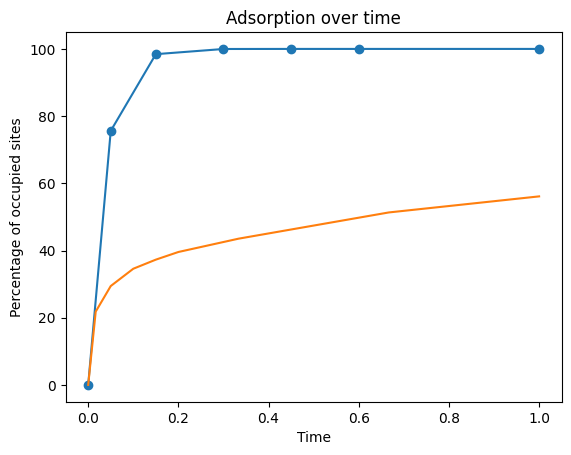

In [ ]:
time_array_1 = np.array([1,3,6,9,12,20,40,60])
plt.plot(time_array/time_array.max(),occupancy.values(), marker='o')
plt.plot(np.insert(time_array_1/time_array_1.max(), 0, 0),np.insert(exp_data, 0, 0))

plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()